In [1]:
import configparser
import os
import h5py
import sys 
import numpy as np
import ctypes
from matplotlib import pyplot as plt
import glob
import xarray as xr
import pandas as pd

In [ ]:
# Set the path to where libcrtm.so was built
libcrtm_path = "/PATH_TO_PYCRTM/pycrtm/ext/CRTMv3/build/lib"

# Prepend it to LD_LIBRARY_PATH
os.environ["LD_LIBRARY_PATH"] = libcrtm_path + ":" + os.environ.get("LD_LIBRARY_PATH", "")

# Restart the kernel with the updated environment (won't work from inside Jupyter though)
# So we need to load the library using ctypes instead (safe workaround)

ctypes.CDLL(os.path.join(libcrtm_path, "libcrtm.so"))

<CDLL '/data3/adhall2/NOAA-15_ScratchFolder/environment1/ScratchFolder/pycrtm/ext/CRTMv3/build/lib/libcrtm.so', handle 55982bec68a0 at 0x7fe7263bd310>

In [4]:
from pyCRTM import pyCRTM, profilesCreate

In [5]:
ds_ocean = xr.open_dataset('ds_ocean_era5.nc')


In [6]:
ds_ocean

<xarray.Dataset> Size: 234GB
Dimensions:         (time: 124, level: 37, latitude: 721, longitude: 1440)
Coordinates:
  * latitude        (latitude) float32 3kB 90.0 89.75 89.5 ... -89.75 -90.0
  * level           (level) int32 148B 1 2 3 5 7 10 ... 875 900 925 950 975 1000
  * time            (time) datetime64[ns] 992B 2023-03-01 ... 2023-03-31T18:0...
    number          int64 8B ...
    expver          (time) <U4 2kB ...
  * longitude       (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
Data variables:
    cc              (time, level, latitude, longitude) float64 38GB ...
    o3              (time, level, latitude, longitude) float64 38GB ...
    ciwc            (time, level, latitude, longitude) float64 38GB ...
    clwc            (time, level, latitude, longitude) float64 38GB ...
    q               (time, level, latitude, longitude) float64 38GB ...
    t               (time, level, latitude, longitude) float64 38GB ...
    u10             (time, latitude, longitude) float64 1GB ...
    v10             (time, latitude, longitude) float64 1GB ...
    skt             (time, latitude, longitude) float64 1GB ...
    msl             (time, latitude, longitude) float32 515MB ...
    wind_speed      (time, latitude, longitude) float64 1GB ...
    wind_direction  (time, latitude, longitude) float64 1GB ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-04 17:39:41 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [7]:
# Compute Pi interface levels

level = np.asarray(ds_ocean['level'])
nt, nlat, nlon = ds_ocean['time'].size, ds_ocean['latitude'].size, ds_ocean['longitude'].size
nlevels = ds_ocean['level'].size

logP = np.log(level)
logPi = np.zeros(nlevels + 1)
logPi[1:-1] = 0.5 * (logP[:-1] + logP[1:])
logPi[0] = logP[0] - (logP[1] - logP[0])
logPi[-1] = logP[-2] + (logP[-2] - logP[-3])
Pi = np.exp(logPi)
ds_ocean['interface_plevs'] = Pi

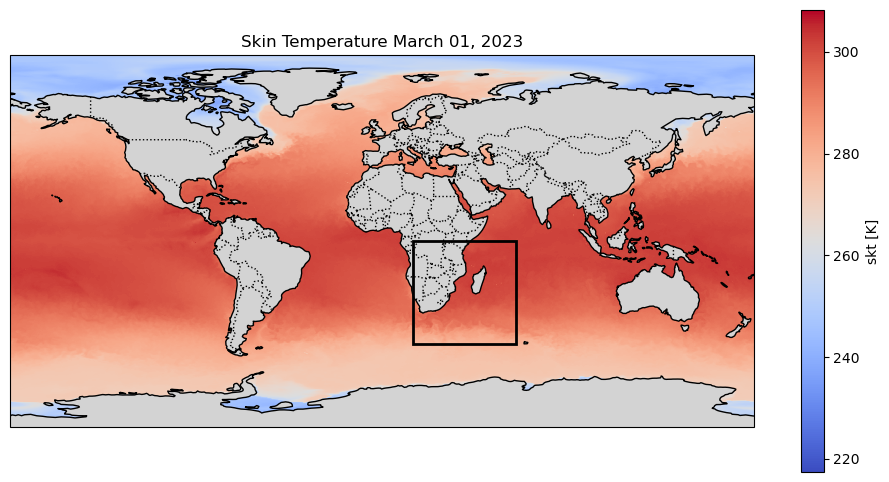

In [8]:
# going to subset the bay of bengal

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle

var_name = 'skt'  # Replace with your variable name

# Select the first time step
data = ds_ocean[var_name].isel(time=0)

# Define Bay of Bengal region
lat_min, lat_max = -50, 0
lon_min, lon_max = 15, 65

# Plot
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': f'{var_name} [K]'})

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='azure')

# Add rectangle box over Bay of Bengal
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                 linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
ax.add_patch(rect)

# Set extent if needed (optional)
# ax.set_extent([60, 110, -10, 40])  

ax.set_title('Skin Temperature March 01, 2023')
plt.show()


In [9]:
# Subset
ds_subset = ds_ocean.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max)
).isel(time=slice(0, 124))



In [10]:
ds_subset

<xarray.Dataset> Size: 9GB
Dimensions:          (time: 124, level: 37, latitude: 201, longitude: 201,
                      interface_plevs: 38)
Coordinates:
  * latitude         (latitude) float32 804B 0.0 -0.25 -0.5 ... -49.75 -50.0
  * level            (level) int32 148B 1 2 3 5 7 10 ... 900 925 950 975 1000
  * time             (time) datetime64[ns] 992B 2023-03-01 ... 2023-03-31T18:...
    number           int64 8B ...
    expver           (time) <U4 2kB ...
  * longitude        (longitude) float32 804B 15.0 15.25 15.5 ... 64.75 65.0
  * interface_plevs  (interface_plevs) float64 304B 0.5 1.414 ... 1.001e+03
Data variables:
    cc               (time, level, latitude, longitude) float64 1GB ...
    o3               (time, level, latitude, longitude) float64 1GB ...
    ciwc             (time, level, latitude, longitude) float64 1GB ...
    clwc             (time, level, latitude, longitude) float64 1GB ...
    q                (time, level, latitude, longitude) float64 1GB ...
    t                (time, level, latitude, longitude) float64 1GB ...
    u10              (time, latitude, longitude) float64 40MB ...
    v10              (time, latitude, longitude) float64 40MB ...
    skt              (time, latitude, longitude) float64 40MB ...
    msl              (time, latitude, longitude) float32 20MB ...
    wind_speed       (time, latitude, longitude) float64 40MB ...
    wind_direction   (time, latitude, longitude) float64 40MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-04 17:39:41 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
from pyCRTM import pyCRTM, profilesCreate
import pandas as pd

def run_pycrtm(ds_ocean, lat_min, lat_max, lon_min, lon_max,
               output_dir="/OUTPUT_DIR"):

    var_name = 'skt'

    # Plot selected region
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    data = ds_ocean[var_name].isel(time=0)
    data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': f'{var_name} [K]'})
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='azure')
    rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                     linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
    ax.add_patch(rect)
    ax.set_title('Skin Temperature March 01, 2023')
    plt.show()

    # Subset, because I am impatient
    ds_subset = ds_ocean.sel(
        latitude=slice(lat_max, lat_min),
        longitude=slice(lon_min, lon_max)
    ).isel(time=slice(0, 124))

    t = ds_subset['t'].values
    q = ds_subset['q'].values
    o3 = ds_subset['o3'].values
    cc = ds_subset['cc'].values
    skt = ds_subset['skt'].values
    p = ds_subset['level'].values
    datetime = ds_subset['time'].values

    if p[0] > p[-1]:
        t = t[:, ::-1, :, :]
        q = q[:, ::-1, :, :]
        o3 = o3[:, ::-1, :, :]
        cc = cc[:, ::-1, :, :]
        p = p[::-1]

    logP = np.log(p)
    logPi = np.zeros(len(p) + 1)
    logPi[1:-1] = 0.5 * (logP[:-1] + logP[1:])
    logPi[0] = logP[0] - (logP[1] - logP[0])
    logPi[-1] = logP[-1] + (logP[-1] - logP[-2])
    Pi = np.exp(logPi)

    nt, nlev, nlat, nlon = t.shape
    n_profiles = nt * nlat * nlon
    t_flat = t.transpose(0, 2, 3, 1).reshape(n_profiles, nlev)
    q_flat = q.transpose(0, 2, 3, 1).reshape(n_profiles, nlev)
    o3_flat = o3.transpose(0, 2, 3, 1).reshape(n_profiles, nlev)
    cc_flat = cc.transpose(0, 2, 3, 1).reshape(n_profiles, nlev)
    skt_flat = skt.reshape(n_profiles)
    pi_flat = Pi[None, :].repeat(n_profiles, axis=0)

    dt_pd = pd.to_datetime(datetime)
    years = np.repeat(dt_pd.year, nlat * nlon)
    months = np.repeat(dt_pd.month, nlat * nlon)
    days = np.repeat(dt_pd.day, nlat * nlon)
    hours = np.repeat(dt_pd.hour, nlat * nlon)

    # Initial NaN/Inf mask
    valid_mask = (
        np.all(np.isfinite(t_flat), axis=1) &
        np.all(np.isfinite(q_flat), axis=1) &
        np.all(np.isfinite(o3_flat), axis=1) &
        np.all(np.isfinite(cc_flat), axis=1) &
        np.isfinite(skt_flat)
    )

    # Physical range checks
    def is_profile_valid(t, q, o3, cc, skt):
        return (
            np.all((t > 100) & (t < 400)) and
            np.all((q >= 0) & (q < 0.1)) and
            np.all((o3 >= 0) & (o3 < 1e-4)) and
            np.all((cc >= 0) & (cc <= 1)) and
            np.isfinite(skt) and (150 < skt < 350)
        )

    profile_mask = np.array([
        is_profile_valid(ti, qi, o3i, cci, skti)
        for ti, qi, o3i, cci, skti in zip(t_flat, q_flat, o3_flat, cc_flat, skt_flat)
    ])

    valid_mask &= profile_mask

    n_valid = valid_mask.sum()
    if n_valid == 0:
        print("No valid profiles in tile.")
        return None

    t_valid = t_flat[valid_mask]
    q_valid = q_flat[valid_mask]*1000 # convert to g/kg
    o3_valid = o3_flat[valid_mask]
    cc_valid = cc_flat[valid_mask]
    skt_valid = skt_flat[valid_mask]
    pi_valid = pi_flat[valid_mask]
    years_valid = years[valid_mask]
    months_valid = months[valid_mask]
    days_valid = days[valid_mask]
    hours_valid = hours[valid_mask]

    if not np.all(np.isfinite(pi_valid)):
        print("Invalid Pi detected in tile, skipping...")
        return None

    profiles = profilesCreate(n_valid, nlev)
    profiles.T[:, :] = t_valid
    profiles.Q[:, :] = q_valid
    profiles.O3[:, :] = o3_valid
    profiles.cloudFraction[:, :] = cc_valid
    profiles.cloudType[:, 0] = 1
    profiles.P[:, :] = p[None, :]
    profiles.Pi[:, :] = pi_valid
    profiles.surfaceTemperatures[:, :] = skt_valid[:, None]
    profiles.surfaceTypes[:, :] = np.array([10., 1., 7., 1., 2., 1.])
    profiles.surfaceFractions[:, :] = np.array([0.0, 1.0, 0.0, 0.0])
    profiles.Angles[:, :] = np.tile([0.0, 999.9, 100.0, 0.0, 0.0], (n_valid, 1)) #[1] isthe sat azimuth, set to 0 for ascending and 180 for descending
    profiles.DateTimes[:, 0] = years_valid
    profiles.DateTimes[:, 1] = months_valid
    profiles.DateTimes[:, 2] = days_valid
    profiles.DateTimes[:, 3] = hours_valid

    try:
        crtm = pyCRTM()
        crtm.sensor_id = 'amsua_n15'
        crtm.nThreads = 64
        crtm.profiles = profiles
        crtm.loadInst()
        crtm.runDirect()
    except Exception as e:
        print(f"CRTM crashed with error: {e}")
        return None

    bt_full = np.full((n_profiles, crtm.Bt.shape[1]), np.nan)
    bt_full[valid_mask] = crtm.Bt
    bt_reshaped = bt_full.reshape(nt, nlat, nlon, crtm.Bt.shape[1]).transpose(0, 3, 1, 2)

    print("CRTM run complete. Output shape:", bt_reshaped.shape)

    # === Save to NetCDF ===
    os.makedirs(output_dir, exist_ok=True)
    bt_da = xr.DataArray(
        bt_reshaped,
        dims=["time", "channel", "latitude", "longitude"],
        coords={
            "time": ds_subset.time,
            "channel": np.arange(bt_reshaped.shape[1]),
            "latitude": ds_subset.latitude,
            "longitude": ds_subset.longitude
        },
        name="brightness_temperature"
    )
    fname = f"bt_lat{lat_min:.1f}_{lat_max:.1f}_lon{lon_min:.1f}_{lon_max:.1f}.nc"
    bt_da.to_netcdf(os.path.join(output_dir, fname))
    print(f"Saved: {fname}")

    return bt_reshaped


In [11]:
# run_pycrtm(ds_ocean, 50.0, 90.0, 0.0, 120.0)


In [12]:
# run_pycrtm(ds_ocean, 50.0, 90.0, 120.0, 180.0)


In [13]:
# run_pycrtm(ds_ocean, 50.0, 90.0, -120.0, 0.0)


In [14]:
# run_pycrtm(ds_ocean, 50.0, 90.0, -180.0, -120.0)


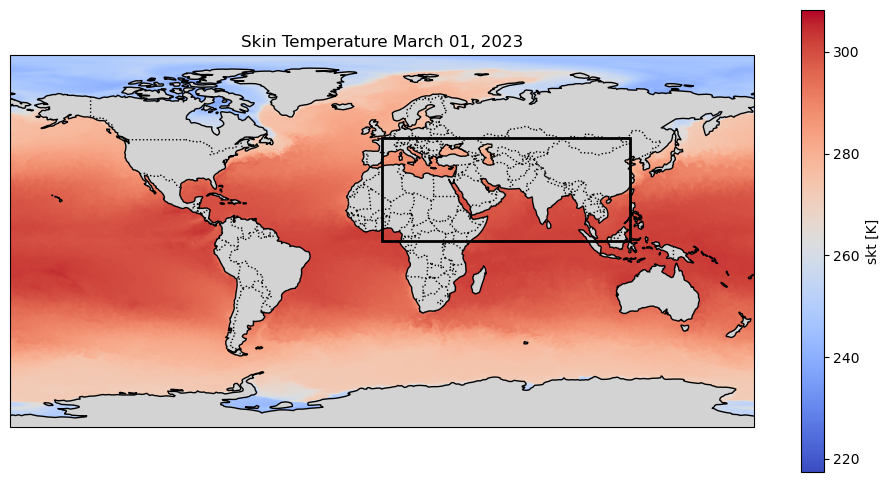

Using netCDF.

     **********************************************************
                            wrap_forward

      Running simulation.

      CRTM Version: v3.1.1
     **********************************************************


     Initializing the CRTM...

     Processing a total of 15 channels...

     Destroying the CRTM...
 wrap_forward done!
✅ CRTM run complete. Output shape: (124, 15, 201, 481)
💾 Saved: bt_lat0.0_50.0_lon0.0_120.0.nc


array([[[[138.02978368, 138.01023461, 138.03398767, ...,          nan,
                   nan,          nan],
         [137.48985766,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [199.08201039, 199.75682447, 199.49719183, ..., 190.85955376,
          192.44154102, 193.0334976 ],
         [199.75182929, 200.26324292, 199.7764199 , ..., 196.75287884,
          198.14967734,          nan],
         [199.99272148, 200.31137671, 199.93585496, ..., 201.70635966,
          201.67911235,          nan]],

        [[143.6931493 , 143.75232122, 143.81287315, ...,          nan,
                   nan,          nan],
         [143.68563109,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          

In [15]:
run_pycrtm(ds_ocean, 0.0, 50.0, 0.0, 120.0)


In [16]:
# run_pycrtm(ds_ocean, 0.0, 50.0, 120.0, 180.0)


In [17]:
# run_pycrtm(ds_ocean, 0.0, 50.0, -120.0, 0.0)


In [18]:
# run_pycrtm(ds_ocean, 0.0, 50.0, -180.0, -120.0)


In [19]:
# run_pycrtm(ds_ocean, -50.0, 0.0, 0.0, 120.0)


In [20]:
# run_pycrtm(ds_ocean, -50.0, 0.0, 120.0, 180.0)


In [21]:
# run_pycrtm(ds_ocean, -50.0, 0.0, -120.0, 0.0)


In [22]:
# run_pycrtm(ds_ocean, -50.0, 0.0, -180.0, -120.0)


In [23]:
# run_pycrtm(ds_ocean, -90.0, -50.0, 0.0, 120.0)


In [24]:
# run_pycrtm(ds_ocean, -90.0, -50.0, 120.0, 180.0)


In [25]:
# run_pycrtm(ds_ocean, -90.0, -50.0, -120.0, 0.0)


In [26]:
# run_pycrtm(ds_ocean, -90.0, -50.0, -180.0, -120.0)
